# CSS Citation Sentiment Example (10/21)

Overview: this is part of a larger project of Jeremy Freese's that involves documenting the characteristics of "null fields" of scientific research. This notebook details a particular feature of this project - citation sentiment analysis - and its application to a few papers. The code and methodological details for the sentiment analysis are taken from Kilacoglu et al (2019); see their paper here: https://www.sciencedirect.com/science/article/pii/S1532046419300413?via%3Dihub and their github here: https://github.com/kilicogluh/clinical-citation-sentiment

In [1]:
#######################################################
# code summary: the goal of this code is to develop a
# citation network around candidate genes
#######################################################

# set working directory to the GitHub
import os
os.chdir('C:\\Users\\tyler\\Documents\\GitHub\\Wallaroo\\Gene_cites')

### First, find papers in PubMed that cite our paper of interest

In [3]:
# identify articles in the open access subset that were published since 2000
pmid = 12869766
db = "pubmed" # Caspi et al is in the pubmed set, but later we'll use PMC
retmode = "json"

# articles that cite the paper - don't loop this command (due to robots.txt restrictions)
tup = ("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=",db,
      "&linkname=pubmed_pmc_refs&id=", pmid)

url = ''.join(map(str, tup))
print(url)

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pmc_refs&id=12869766


In [6]:
# now, put our output in beautifulsoup format
from bs4 import BeautifulSoup
from urllib.request import urlopen
html = urlopen(url)
bs = BeautifulSoup(html.read(), 'xml')
# find ids within set of citations 
idlist = bs.find('LinkSetDb').find_all('Id',{}) # (excluding original paper id)    

# print the PMC ids of articles that cite Caspi et al (only first 10)
print(len(idlist)) # 1595 citations
print(idlist[:10])

1713
[<Id>7555071</Id>, <Id>7539902</Id>, <Id>7537828</Id>, <Id>7524411</Id>, <Id>7508939</Id>, <Id>7501125</Id>, <Id>7474769</Id>, <Id>7450762</Id>, <Id>7446184</Id>, <Id>7445164</Id>]


### Next, pull the full text of those papers (if they are in the open access subset)
For more details on the open access subset, see here: https://www.ncbi.nlm.nih.gov/pmc/tools/openftlist/ 

In [9]:
# this code would be within a function, to run on the entire list of ids from the above code
id = idlist[0]
cite_tup = ("https://www.ncbi.nlm.nih.gov/pmc/oai/oai.cgi?verb=GetRecord&identifier=oai:pubmedcentral.nih.gov:",
id.get_text(),"&metadataPrefix=pmc")
cite_url = ''.join(map(str,cite_tup))
print(cite_url)

https://www.ncbi.nlm.nih.gov/pmc/oai/oai.cgi?verb=GetRecord&identifier=oai:pubmedcentral.nih.gov:7555071&metadataPrefix=pmc


In [27]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
# now we begin to extract citing sentences
# look in pmc, because these have full text available
sentences_df = pd.read_csv("sentences_df.txt", header = None, sep = "jfdkls;fjasi;osjeioa;")

# rename column
sentences_df = sentences_df.rename(columns = {0:'Citing Sentence'})

# look at single example
sentences_df[:1]

C:\Users\tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,Citing Sentence
0,"The 5-HT gene could moderate the serotonergic response to stress [<cit id=""1779383"">[B4]</cit>]."


### Now let's classify the sentence!
The classifier is the 'best model' from the Kilacoglu et al (2019) paper. It is based on a Convolution Neural Network (CNN) model with hand-crafted features. The model was built using a set of over 4,000 citations, and performs well compared to other similar models in the field (0.882 accuracy and 0.721 macro- F1 on held-out set). Like other corpuses, most of the citations in this set were neutral (75%), and only a small number were negative (8%). The negative (and positive) citations have the worst recall scores in the CNN model (0.34, 0.68), although their precision scores are much better (0.93, 0.78). 

In [33]:
import csv
# put it in a dataframe, then csv first (I'm sure there's an easier way to this)
sentence = sentences_df['Citing Sentence'][0]

single_sent = pd.DataFrame({
             'citing sentence': [sentence]
            })

single_sent.to_csv('clinical-citation-sentiment-master/single_sent.txt', index = False, header = False,  quoting = csv.QUOTE_NONE, sep = '{',
        escapechar = '\\')
    
##### this is the only code needed to actually run the classifier!!    
os.system("cd C:/Users/tyler/Documents/GitHub/Wallaroo/Gene_cites/clinical-citation-sentiment-master/")
os.system("py scripts/predict_python3.py single_sent.txt single_sent_output.txt")

# now, output file
temp_output = pd.read_csv('clinical-citation-sentiment-master/single_sent_output.txt', sep=" ", header=None)
    
temp_output['Citing Sentence'] = sentence

temp_output.rename(columns = {0:'ID', 1:'Sentiment'})

,ID,Sentiment,Citing Sentence
0,1779383:[B4],NEUTRAL,"The 5-HT gene could moderate the serotonergic response to stress [<cit id=""1779383"">[B4]</cit>]."


## The following code imports citation sentences


In [37]:
# import citation sentences with sentiments
sentences_df_corder = pd.read_csv("clinical-citation-sentiment-master\\sentences_df_corder.csv")
sentences_df_corder['paper'] = "corder"

sentences_df_caspi = pd.read_csv("clinical-citation-sentiment-master\\sentences_df_caspi.csv")
sentences_df_caspi['paper'] = "caspi"

sentences_df_lesch = pd.read_csv("clinical-citation-sentiment-master\\sentences_df_lesch.csv")
sentences_df_lesch['paper'] = "lesch"

sentences_df_strittmatter = pd.read_csv("clinical-citation-sentiment-master\\sentences_df_strittmatter.csv")
sentences_df_strittmatter['paper'] = "strittmatter"

# merge data with all papers
sentences_df = pd.concat([sentences_df_corder, sentences_df_caspi, sentences_df_lesch, sentences_df_strittmatter])

C:\Users\tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


In [52]:
# change name to MedAbbr
sentences_df = sentences_df.rename(columns={"journal": "MedAbbr"})

# pull out year, month, day
date_expanded = sentences_df.pub_date.str.split(" ") 

# add blanks for items missing dates
for elem in date_expanded:
    for i in range(3 - len(elem)):
        elem.append("")


# may need to do an ['extra'] column as well here, and drop it, depending on how dates are listed
sentences_df[['Year', 'Month', 'Day']] = pd.DataFrame(date_expanded.tolist(),
                                                              index= date_expanded.index)

# get rid of unnecessary column
#sentences_df = sentences_df.drop(['Extra'], axis = 1)

sentences_df.columns

Index(['Day', 'Month', 'Year', 'cit_sent', 'cite_id', 'cite_id_check',
       'citing sentence', 'id', 'MedAbbr', 'paper', 'pmc_id', 'pub_date',
       'pubmed_id'],
      dtype='object')

## Let's take a look at a few examples

In [63]:
sentences_df.loc[(sentences_df['cit_sent'] == "NEGATIVE") & (sentences_df['paper'] == "caspi")][['citing sentence', 'cit_sent']][:5]

,citing sentence,cit_sent
230,"This requires detailed understanding of interaction between early life experiences and factors that contribute to vulnerability or resilience, such as function of GRs (Klengel et al., 2013) and MRs (Kuningas et al., 2007, Klok et al., 2015, Otte et al., 2015, Kanatsou et al., 2015), but also other genes (<cit id=""5314442"">[bib19]</cit>), and how they interact with the circuitry that underlies e.g. fear behavior.",NEGATIVE
307,"3–<cit id=""4540121"">[b6-ndt-11-2079]</cit>,12 However, the association between childhood abuse and affective temperament at the onset of MDD has not been clarified.",NEGATIVE
376,"<cit id=""4119224"">[bib4]</cit> Although some meta-analyses could not confirm this gene × environment (G × E) interaction,5,6 others have shown that it is especially significant after a history of early life stress (ELS).",NEGATIVE
462,"Moreover, they identified that childhood maltreatment predicted adult depression in individuals carrying the short allele but not in individuals homozygous for the long allele (P = 0.5) [<cit id=""3668172"">[B221]</cit>].",NEGATIVE
498,"In order to examine the association between 5-HTT genotype and depression, Risch et al12 performed a meta-analysis of 14 replication studies (n = 14,250) and found that many of the trials failed to reproduce the results reported by Caspi et al.<cit id=""3513226"">[b7-pgpm-5-019]</cit> Furthermore, other studies reviewed were only able to replicate the results partially or even produced contradictory results.",NEGATIVE


In [64]:
sentences_df.loc[(sentences_df['cit_sent'] == "POSITIVE") & (sentences_df['paper'] == "caspi")][['citing sentence', 'cit_sent']][:5]

,citing sentence,cit_sent
11,"In an early and important paper, Caspi and colleagues reported that subjects with one or two copies of the short D allele of the 5-HTTLPR promoter polymorphism exhibited more depressive symptoms and suicidality in relation to stressful life events than individuals homozygous for the long I allele (Caspi et al. <cit id=""7378120"">[CR13]</cit>).",POSITIVE
43,"Thus, according to Caspi et al. [<cit id=""6896020"">[B4-brainsci-09-00311]</cit>], the risk of depression and post traumatic disorders in patients with these polymorphisms can be observed more frequently when they are put under stress or adverse environmental conditions.",POSITIVE
45,"In Bogdan et al. [9] research in a group of 234 children has shown similar results to Caspi et al. [<cit id=""6896020"">[B4-brainsci-09-00311]</cit>].",POSITIVE
48,"Individuals homozygous for the S allele of the polymorphism were more susceptible to the negative effects of life stressors in early childhood than those homozygous for the L allele, resulting in an increased risk for major depression (Caspi et al. <cit id=""6884432"">[CR4]</cit>; Kaufman et al. 2004; Kendler et al. 2005, but see Munafò et al. 2008 and Risch et al. 2009).",POSITIVE
79,"The potential of the molecular genetics approach has been illustrated by a recent study that found an association between a variant of the serotonin transporter gene and major depression, but only in people who had experienced stressful life events (<cit id=""6601672"">[b1-222-229]</cit>).",POSITIVE


## Now, merge the citation sentences with journal info

In [40]:
# import data with journal names, ids, and citescores
cs_df = pd.read_csv("cs_df.csv")

# now merge journal information and citing sentences
sentences_cs_df = cs_df.merge(sentences_df, 'right')

# just look at first one
sentences_cs_df[:1]

,index,CiteScore,E-ISSN,ISSN (Online),ISSN (Print),IsoAbbr,JournalTitle,JrId,MedAbbr,NlmId,...,Year,cit_sent,cite_id,cite_id_check,citing sentence,id,paper,pmc_id,pub_date,pubmed_id
0,95.0,4.655556,NaN,0219-1032,1016-8478,Mol. Cells,Molecules and cells,8634.0,Mol Cells,9610936,...,2019,NEUTRAL,NaN,NaN,"Among identified genetic risk factors for LOAD, the most influential factor, for which the odds ratio is above 10 for homozygotes and found in about 40% of patients, is located on the APOE gene encoding apolipoprotein E (<cit id=""6883979"">[b16-molce-42-739]</cit>).",6883979,corder,PMC6883979,2019 Nov 12,31711277


In [48]:
### get summary statistics on the sentiments for each paper

# create summary table 
tab1 = pd.crosstab(sentences_cs_df['paper'], sentences_cs_df['cit_sent'])
tab1['TOTAL'] = tab1['POSITIVE'] + tab1['NEGATIVE'] + tab1['NEUTRAL']
tab1['% POSITIVE'] = tab1['POSITIVE']/tab1['TOTAL']
tab1['% NEGATIVE'] = tab1['NEGATIVE']/tab1['TOTAL']

# view table
tab1

cit_sent,NEGATIVE,NEUTRAL,POSITIVE,TOTAL,% POSITIVE,% NEGATIVE
paper,,,,,,
caspi,9,588,67,664,0.100904,0.013554
corder,6,837,86,929,0.092573,0.006459
lesch,7,485,62,554,0.111913,0.012635
strittmatter,1,275,19,295,0.064407,0.003390


In [49]:
### get summary statistics on the types of journals (citescores)
### where the positive, negative, and neutral citations come from

sentences_cs_df.groupby(['cit_sent'])['CiteScore'].describe()

,count,mean,std,min,25%,50%,75%,max
cit_sent,,,,,,,,
NEGATIVE,8.0,7.076389,6.278030,1.988889,3.522222,4.761111,7.525000,21.244444
NEUTRAL,856.0,7.319615,5.885590,0.611111,3.400000,5.311111,8.266667,51.788889
POSITIVE,102.0,6.927116,4.852836,0.762500,4.233333,5.177778,8.266667,22.522222


In [291]:
# look at distribution of negative, neutral, positive citations
pd.crosstab([sentences_cs_df['paper'], sentences_cs_df['cit_sent']], sentences_cs_df['Year'])

Year                   1995  1997  1999  2000  2001  2002  2003  2004  2005  \
paper        cit_sent                                                         
caspi        NEGATIVE     0     0     0     0     0     0     0     0     0   
             NEUTRAL      0     0     0     0     0     0     2     4     3   
             POSITIVE     0     0     0     0     0     0     0     1     0   
corder       NEGATIVE     0     0     0     0     0     0     0     0     0   
             NEUTRAL      1     1     1     1     1     0     3     4     5   
             POSITIVE     0     0     0     0     0     0     0     0     0   
lesch        NEGATIVE     0     0     0     0     0     0     0     0     0   
             NEUTRAL      0     0     0     0     2     6     1     6     7   
             POSITIVE     0     0     0     0     0     1     1     0     0   
strittmatter NEGATIVE     0     0     0     0     0     0     0     0     0   
             NEUTRAL      0     0     0     0     0     0     3     1     2   
             POSITIVE     0     0     0     0     0     0     0     1     0   

Year                   2006  ...   2011  2012  2013  2014  2015  2016  2017  \
paper        cit_sent        ...                                              
caspi        NEGATIVE     0  ...      2     2     1     1     1     1     0   
             NEUTRAL     13  ...     22    37    61    56    58    45    60   
             POSITIVE     1  ...      2     4    11     2     7     7     7   
corder       NEGATIVE     1  ...      0     0     1     2     1     0     0   
             NEUTRAL      7  ...     34    37    58    51    59    87   103   
             POSITIVE     1  ...      2     8     2     8     6     5    13   
lesch        NEGATIVE     0  ...      0     1     0     0     1     0     0   
             NEUTRAL      4  ...     31    50    48    35    31    38    41   
             POSITIVE     0  ...      6     3    10     5     6     4     6   
strittmatter NEGATIVE     0  ...      0     0     0     1     0     0     0   
             NEUTRAL      1  ...     14    20    15    14    27    21    34   
             POSITIVE     1  ...      0     3     0     2     1     0     1   

Year                   2018  2019  2020  
paper        cit_sent                    
caspi        NEGATIVE     0     0     0  
             NEUTRAL     46    61    35  
             POSITIVE     7     4     1  
corder       NEGATIVE     1     0     0  
             NEUTRAL    113   112    98  
             POSITIVE    13    14     6  
lesch        NEGATIVE     0     0     0  
             NEUTRAL     43    40    23  
             POSITIVE     4     1     2  
strittmatter NEGATIVE     0     0     0  
             NEUTRAL     38    30    25  
             POSITIVE     2     3     1  

[12 rows x 24 columns]

In [ ]:
# create crosstab with year, paper, and sentiment
cite_year_df = pd.crosstab(sentences_cs_df['Year'], [sentences_cs_df['paper'], sentences_cs_df['cit_sent']])

# stack the results
cite_year_df = cite_year_df.stack(0).stack().reset_index()
# fix column name
cite_year_df = cite_year_df.rename(columns = {0:'Number of Cites'})

### do the same thing for cumulative totals
# create crosstab with year, paper, and sentiment
cite_sum_year_df = pd.crosstab([sentences_cs_df['paper'], sentences_cs_df['cit_sent']], sentences_cs_df['Year'])

#cite_sum_year_df
cite_sum_year_df = cite_sum_year_df.groupby(['paper', 'cit_sent']).apply(lambda x: x.cumsum(axis=1).sum())

# transpose for long dataset
cite_sum_year_df = cite_sum_year_df.transpose()

# stack the results
cite_sum_year_df = cite_sum_year_df.stack(0).stack().reset_index()
# fix column name
cite_sum_year_df = cite_sum_year_df.rename(columns = {0:'Number of Cites'})

# standardize the citations received per year by the total number of citations received throughout the period
#cite_year_df['% of Total Cites'] = 

cite_year_df['Pct of Total Cites'] = cite_year_df['Number of Cites'] / cite_year_df.groupby(['paper'])['Number of Cites'].transform('sum')

## Figures

Text(0.5,1,'Citation Sentiments for Selected Papers')

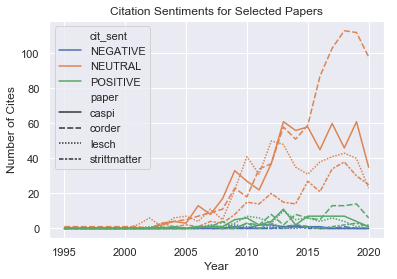

In [293]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#set axes to numeric
cite_year_df['Year'] = pd.to_numeric(cite_year_df['Year'], errors = 'coerce')

# create line plots
lineplot = sns.lineplot(data=cite_year_df, style = 'paper', hue = 'cit_sent', x = 'Year', y = 'Number of Cites')

lineplot.set_title("Citation Sentiments for Selected Papers")

Text(0.5,1,'Citation Sentiments for Selected Papers')

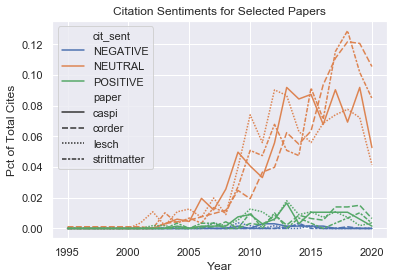

In [318]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#set axes to numeric
cite_year_df['Year'] = pd.to_numeric(cite_year_df['Year'], errors = 'coerce')

# create line plots
lineplot = sns.lineplot(data=cite_year_df, style = 'paper', hue = 'cit_sent', x = 'Year', y = 'Pct of Total Cites')

lineplot.set_title("Citation Sentiments for Selected Papers")

Text(0.5,1,'Impact of Journals with articles citing Selected Papers')

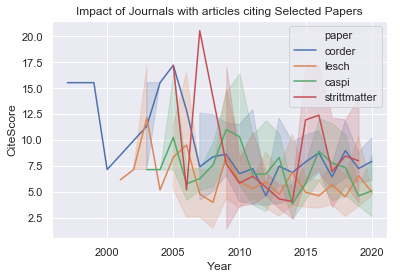

In [296]:
### get summary statistics on the types of journals (citescores)
### where the positive, negative, and neutral citations come from

sentences_cs_df.groupby('Year')['CiteScore'].describe()


# convert year to number
sentences_cs_df['Year'] = pd.to_numeric(sentences_cs_df['Year'], errors = 'coerce')

lineplot = sns.lineplot(x="Year", y="CiteScore", hue = 'paper',
             data=sentences_cs_df.drop_duplicates('pubmed_id'))

lineplot.set_title("Impact of Journals with articles citing Selected Papers")

# Questions?
### What are other  applications of citation sentiment analysis?
### How can we make more use of the negative/positive classifications?
### What are potential pitfalls of these methods?